In [1]:
# from scipy.sparse import csr_matrix

## Входные данные

### Загрузка

In [2]:
# !unzip capstone_user_identification.zip

In [3]:
# from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import pickle
import numpy as np

In [4]:
# PATH_TO_DATA = '../capstone_user_identification'
PATH_TO_DATA = '../input/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2'

times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]
df_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id', parse_dates=times)
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id', parse_dates=times)
df_train.shape, df_test.shape

((253561, 21), (82797, 20))

In [5]:
df_train.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   site1   253561 non-null  int64         
 1   time1   253561 non-null  datetime64[ns]
 2   site2   250098 non-null  float64       
 3   time2   250098 non-null  datetime64[ns]
 4   site3   246919 non-null  float64       
 5   time3   246919 non-null  datetime64[ns]
 6   site4   244321 non-null  float64       
 7   time4   244321 non-null  datetime64[ns]
 8   site5   241829 non-null  float64       
 9   time5   241829 non-null  datetime64[ns]
 10  site6   239495 non-null  float64       
 11  time6   239495 non-null  datetime64[ns]
 12  site7   237297 non-null  float64       
 13  time7   237297 non-null  datetime64[ns]
 14  site8   235224 non-null  float64       
 15  time8   235224 non-null  datetime64[ns]
 16  site9   233084 non-null  float64       
 17  time9   233084 non-null  date

In [7]:
df_train['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

Словарь сайтов

In [8]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as f:
    site2id  = pickle.load(f)
id2site = {v:k for (k, v) in site2id.items()}
id2site[0] = 'unknown'

In [9]:
df_train.sort_values(by='time1', inplace=True)

## Feature engineering

In [10]:
# from scipy.sparse import hstack
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

Рассмотрим признаки:
- Дата
    - час начала сессии
        - утро
        - день
        - вечер
        - ночь
        - циклические координаты (sin|cos часа)
    - месяц
        - сезон
    - год
        - год + месяц
    - день
        - выходной / будний
        - dummies
        - is_monday...
    - длина сессии
        - длина посещений каждого сайта
- Сайт
    - число уникальных сайтов в сессии (сколько повторов за сессию)
    - факт посещения абсолютно уникальных сайтов
    - факт посещения сайтов из топ-10 популярных сайтов
    - посещение определённых сайтов (facebook итд)

In [11]:
time_features_train = pd.DataFrame()
time_features_test = pd.DataFrame()
df_train_times = df_train[times]
df_test_times = df_test[times]

time_features_train['target'] = df_train["target"].astype('int').values

In [12]:
def plot_feature(train, test, plot, x, y=None, bins='auto'):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    if plot == 'countplot':
        sns.countplot(train[x], ax=ax1)
        sns.countplot(test[x], ax=ax2)
        sns.countplot(train[train.target == 1][x], ax=ax3)
        sns.countplot(train[train.target == 0][x], ax=ax4)
    elif plot == 'histplot':
        sns.histplot(train[x], ax=ax1, bins=bins)
        sns.histplot(test[x], ax=ax2, bins=bins)
        sns.histplot(train[train.target == 1][x], ax=ax3, bins=bins)
        sns.histplot(train[train.target == 0][x], ax=ax4, bins=bins)
    elif plot == 'scatterplot':
        sns.scatterplot(x=train[x], y=train[y], ax=ax1)
        sns.scatterplot(x=test[x], y=test[y], ax=ax2)
        sns.scatterplot(x=train[train.target == 1][x], y=train[train.target == 1][y], ax=ax3)
        sns.scatterplot(x=train[train.target == 0][x], y=train[train.target == 0][y], ax=ax4)
#     elif plot == 'barplot':
#         sns.barplot(data=train[x], ax=ax1)
#         sns.barplot(data=train[train.target == 1][x], ax=ax2)
#         sns.barplot(data=test[x], ax=ax3)
    elif plot == 'boxplot':
        sns.boxplot(y=train[x], ax=ax1, orient='h')
        sns.boxplot(y=test[x], ax=ax2, orient='v')
        sns.boxplot(y=train[train.target == 1][x], ax=ax3, orient='v')
        sns.boxplot(y=train[train.target == 0][x], ax=ax4, orient='v')
    ax1.set_title('Train')
    ax2.set_title('Test')
    ax3.set_title('Target')
    ax4.set_title('Non-Target');

### Дата-время

#### Час

In [13]:
time_features_train['hour'] = df_train_times['time1'].apply(lambda ts: ts.hour)
time_features_test['hour'] = df_test_times['time1'].apply(lambda ts: ts.hour)

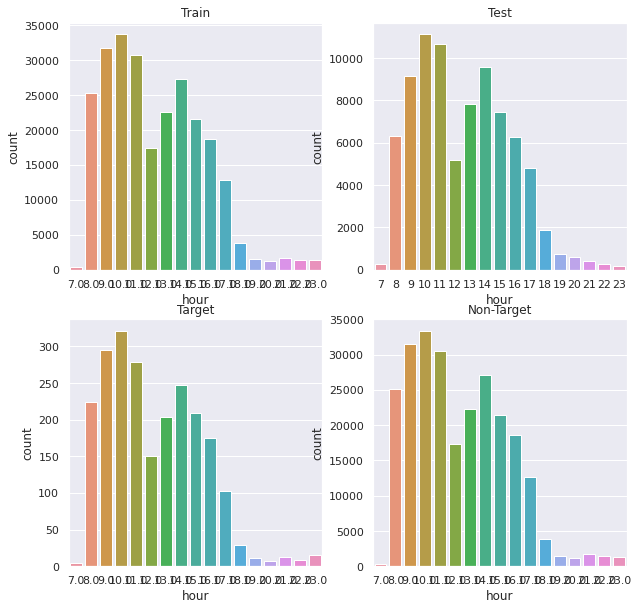

In [14]:
plot_feature(time_features_train, time_features_test, 'countplot', 'hour')

#### Круговые координаты на основе часа

In [15]:
time_features_train['sin_hour'] = df_train_times['time1'].apply(lambda ts: np.sin(2*np.pi*ts.hour/24))
time_features_train['cos_hour'] = df_train_times['time1'].apply(lambda ts: np.cos(2*np.pi*ts.hour/24))
time_features_test['sin_hour'] = df_test_times['time1'].apply(lambda ts: np.sin(2*np.pi*ts.hour/24))
time_features_test['cos_hour'] = df_test_times['time1'].apply(lambda ts: np.cos(2*np.pi*ts.hour/24))

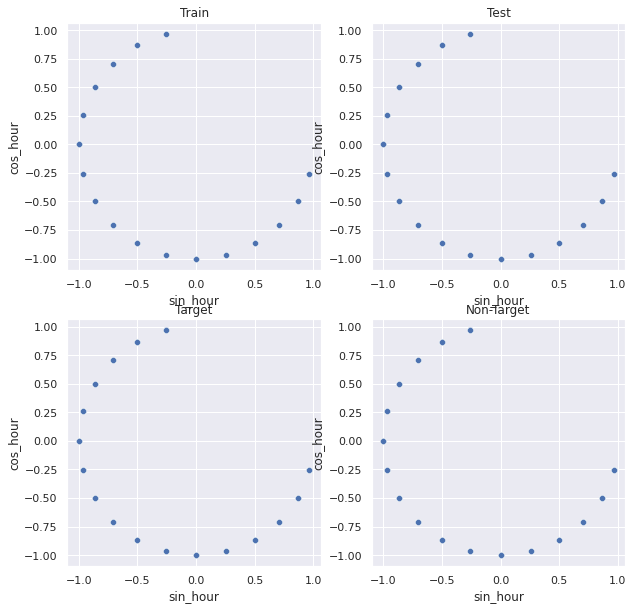

In [16]:
plot_feature(time_features_train, time_features_test, 'scatterplot', 'sin_hour', 'cos_hour')

#### Минуты

In [17]:
time_features_train['minute'] = df_train_times['time1'].apply(lambda ts: ts.minute)
time_features_test['minute'] = df_test_times['time1'].apply(lambda ts: ts.minute)

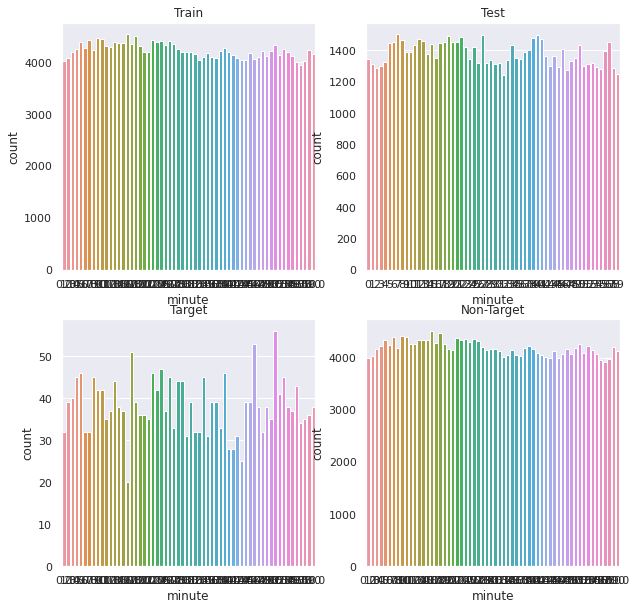

In [18]:
plot_feature(time_features_train, time_features_test, 'countplot', 'minute')

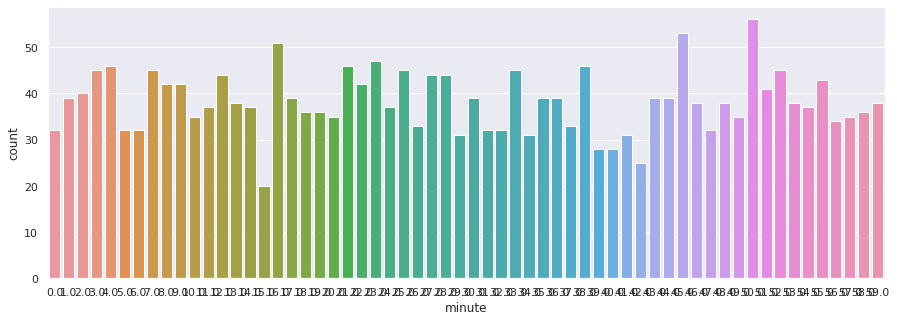

In [20]:
plt.figure(figsize=(15, 5))
sns.countplot(x=time_features_train[time_features_train.target == 1]['minute']);

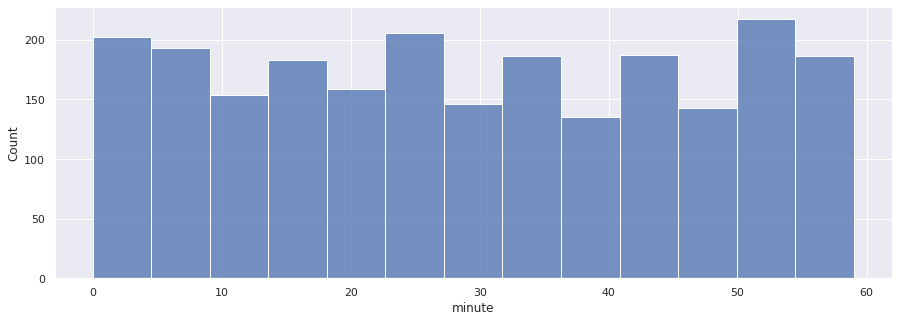

In [21]:
plt.figure(figsize=(15, 5))
sns.histplot(x=time_features_train[time_features_train.target == 1]['minute']);

#### Секундыtarget

In [22]:
time_features_train['second'] = df_train_times['time1'].apply(lambda ts: ts.second)
time_features_test['second'] = df_test_times['time1'].apply(lambda ts: ts.second)

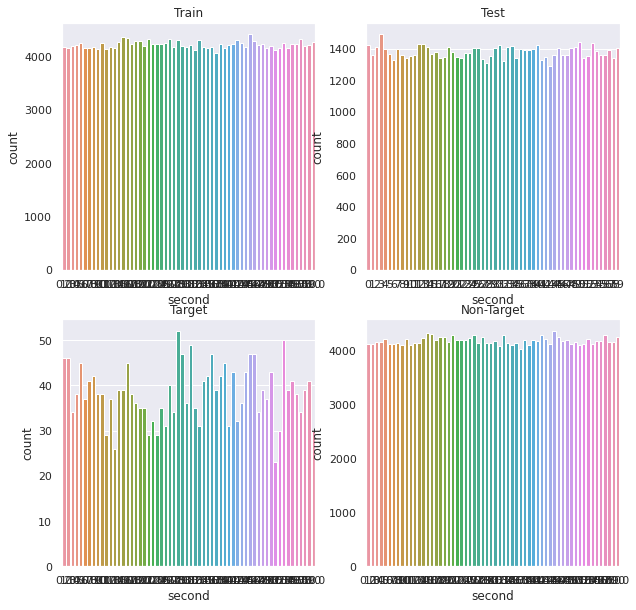

In [23]:
plot_feature(time_features_train, time_features_test, 'countplot', 'second')

#### Час+минуты
Точное распределение по времени суток

In [24]:
time_features_train['hour_minute'] = df_train_times['time1'].apply(lambda ts: (ts.hour * 60 + ts.minute))
time_features_test['hour_minute'] = df_test_times['time1'].apply(lambda ts: (ts.hour * 60 + ts.minute))

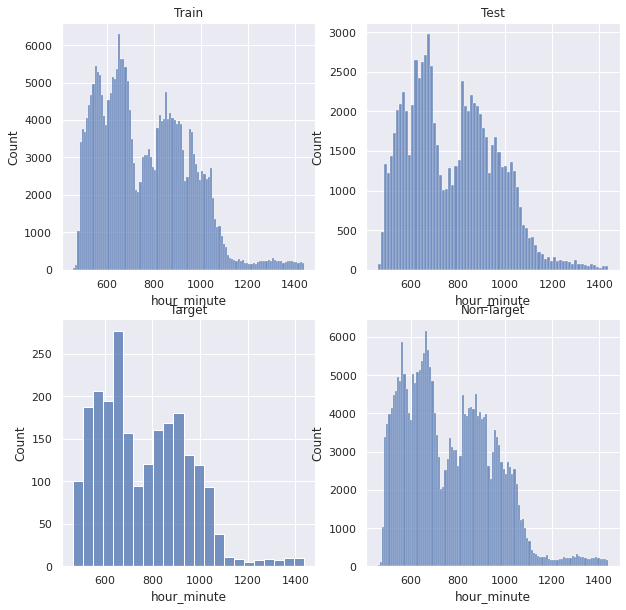

In [25]:
plot_feature(time_features_train, time_features_test, 'histplot', 'hour_minute')

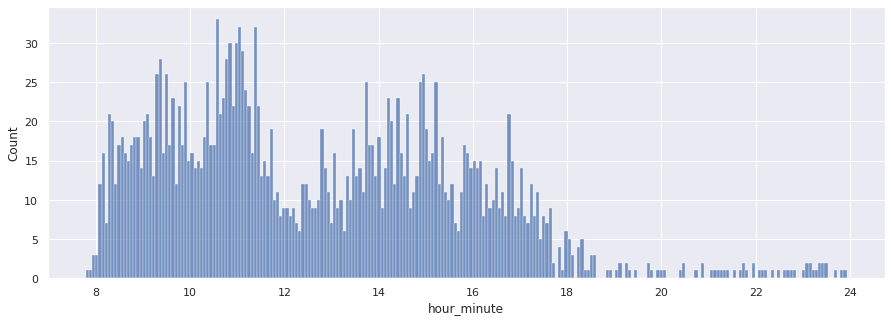

In [26]:
plt.figure(figsize=(15, 5))
sns.histplot(x=time_features_train[time_features_train.target == 1]['hour_minute']/60, bins=240);

#### Месяц

In [27]:
time_features_train['month'] = df_train_times['time1'].apply(lambda ts: ts.month)
time_features_test['month'] = df_test_times['time1'].apply(lambda ts: ts.month)

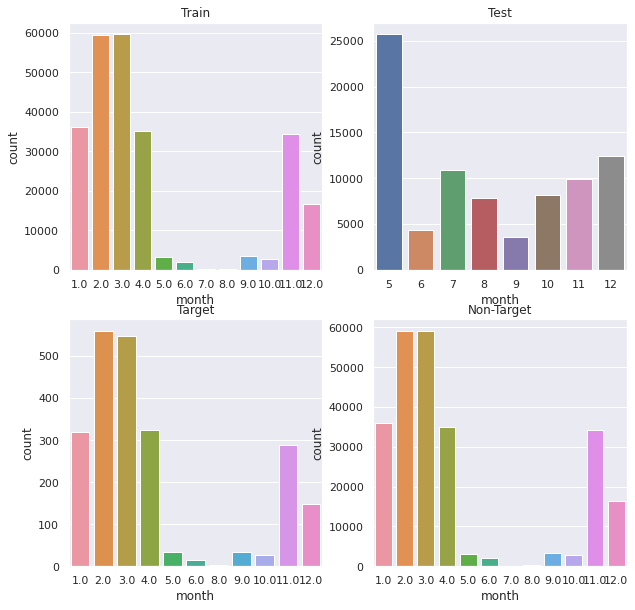

In [28]:
plot_feature(time_features_train, time_features_test, 'countplot', 'month')

#### Год

In [29]:
time_features_train['year'] = df_train_times['time1'].apply(lambda ts: ts.year)
time_features_test['year'] = df_test_times['time1'].apply(lambda ts: ts.year)

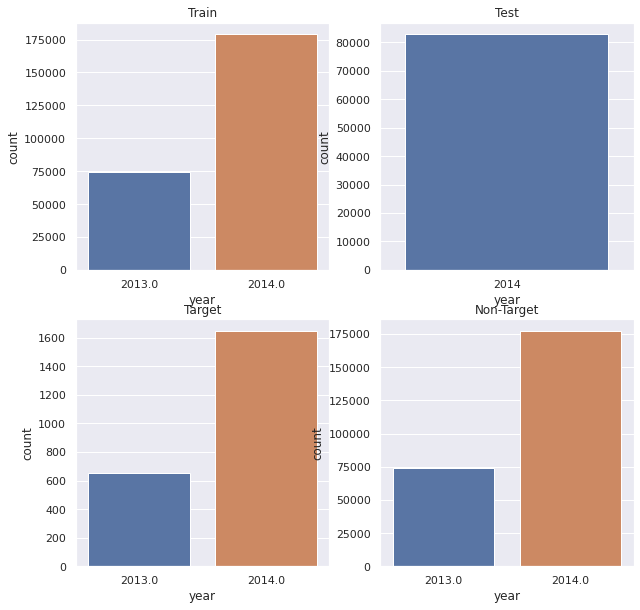

In [30]:
plot_feature(time_features_train, time_features_test, 'countplot', 'year')

In [31]:
time_features_train['year_month'] = df_train_times['time1'].apply(lambda ts: ts.year + (ts.month - 1) / 12)
time_features_test['year_month'] = df_test_times['time1'].apply(lambda ts: ts.year + (ts.month - 1) / 12)

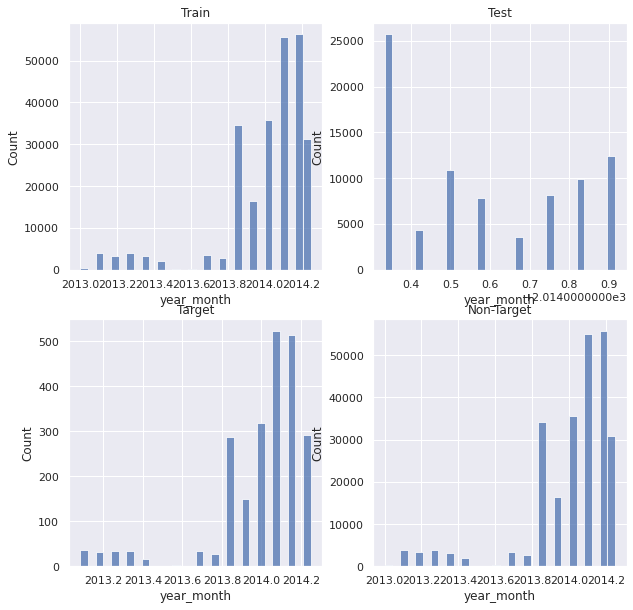

In [32]:
plot_feature(time_features_train, time_features_test, 'histplot', 'year_month', bins=30)

#### День недели

In [33]:
time_features_train['day'] = df_train_times['time1'].apply(lambda ts: ts.weekday())
time_features_test['day'] = df_test_times['time1'].apply(lambda ts: ts.weekday())

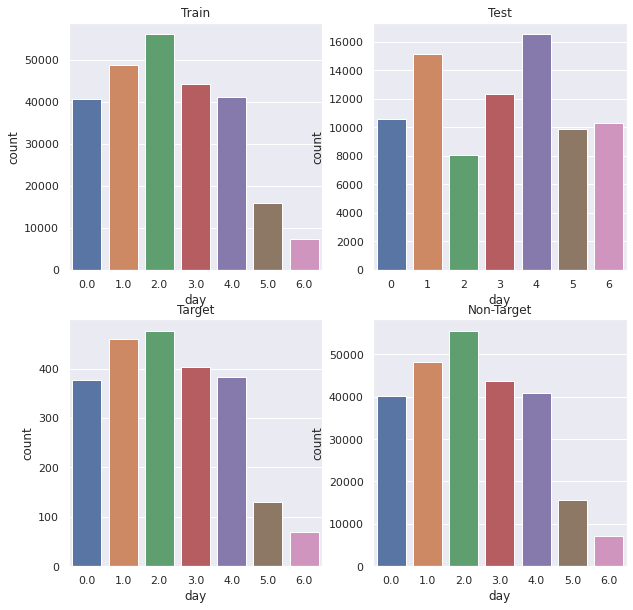

In [34]:
plot_feature(time_features_train, time_features_test, 'countplot', 'day')

#### Длина сессии

In [35]:
%%time
time_features_train['duration'] = df_train_times.apply(lambda row: (row.max() - row.min()).total_seconds(), axis=1)
time_features_test['duration'] = df_test_times.apply(lambda row: (row.max() - row.min()).total_seconds(), axis=1)

CPU times: user 1min 12s, sys: 182 ms, total: 1min 12s
Wall time: 1min 12s


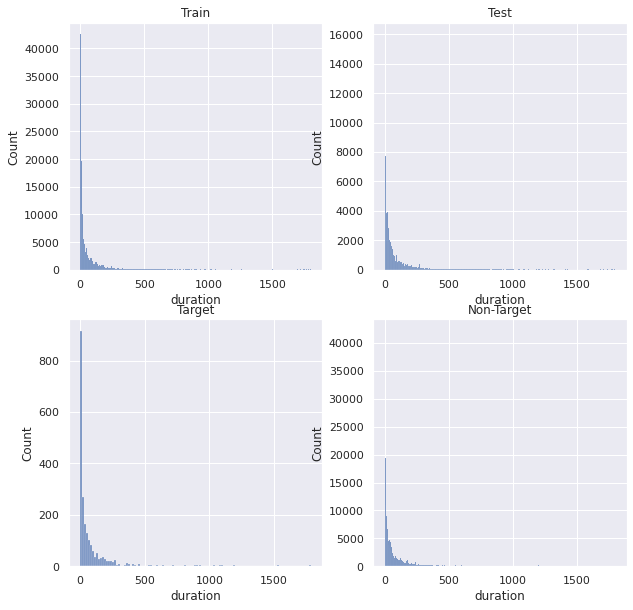

In [36]:
plot_feature(time_features_train, time_features_test, 'histplot', 'duration')

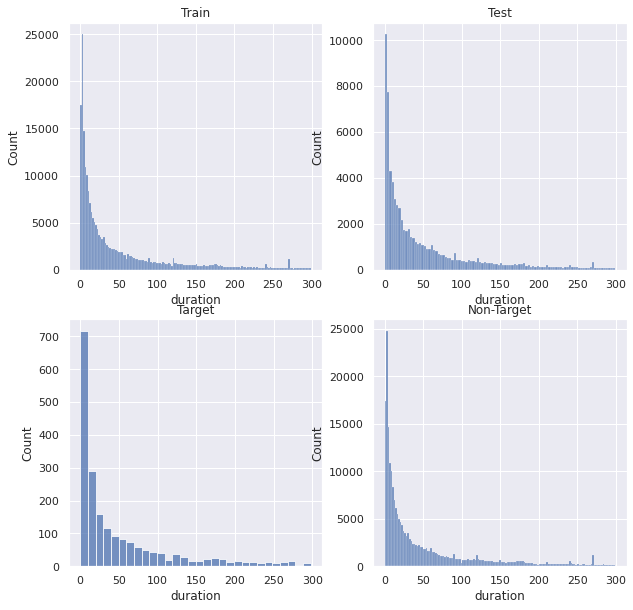

In [37]:
plot_feature(time_features_train[time_features_train.duration < 300], time_features_test[time_features_test.duration < 300], 'histplot', 'duration')

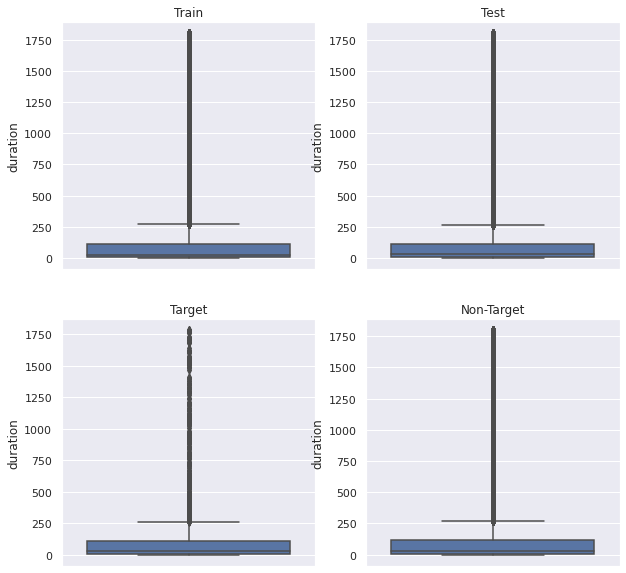

In [38]:
plot_feature(time_features_train, time_features_test, 'boxplot', 'duration')

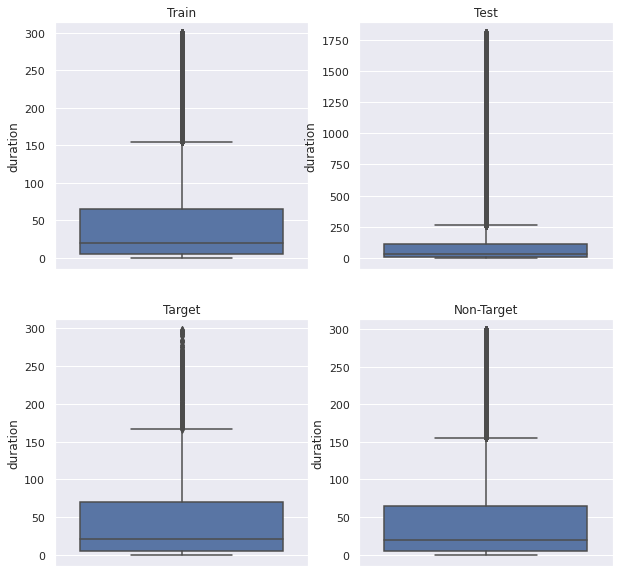

In [39]:
plot_feature(time_features_train[time_features_train.duration < 300], time_features_test[time_features_train.duration < 300], 'boxplot', 'duration')

#### Time diffs

In [40]:
def get_time_diffs(session):
    time_length = session.shape[0] - 1 
    time_diff = [0]*time_length
#     not_na = pd.Series(session)[pd.notna]
    i = 0
    while i < time_length and pd.notnull(session[i+1]):
        time_diff[i] = (session[i+1] - session[i]) / np.timedelta64(1,'s') 
        i += 1
    return pd.Series(time_diff)

In [41]:
%%time
df_train_td = df_train_times.apply(lambda session: get_time_diffs(session), axis=1)
df_test_td = df_test_times.apply(lambda session: get_time_diffs(session), axis=1)

CPU times: user 5min 35s, sys: 2.42 s, total: 5min 38s
Wall time: 5min 38s


In [42]:
time_diffs = [f'time_diff_{i}' for i in range(1, 10)]
df_train_td.columns = time_diffs
df_test_td.columns = time_diffs

In [43]:
time_features_train

,target,hour,sin_hour,cos_hour,minute,second,hour_minute,month,year,year_month,day,duration
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,10.0,0.500000,-0.866025,2.0,45.0,602.0,2.0,2014.0,2014.083333,3.0,0.0
2,0,11.0,0.258819,-0.965926,19.0,50.0,679.0,2.0,2014.0,2014.083333,5.0,26.0
3,0,16.0,-0.866025,-0.500000,40.0,17.0,1000.0,12.0,2013.0,2013.916667,0.0,7.0
4,0,10.0,0.500000,-0.866025,52.0,12.0,652.0,3.0,2014.0,2014.166667,4.0,270.0
...,...,...,...,...,...,...,...,...,...,...,...,...
253556,0,13.0,-0.258819,-0.965926,11.0,57.0,791.0,4.0,2013.0,2013.250000,4.0,16.0
253557,0,10.0,0.500000,-0.866025,26.0,54.0,626.0,11.0,2013.0,2013.833333,0.0,59.0
253558,0,16.0,-0.866025,-0.500000,1.0,15.0,961.0,3.0,2013.0,2013.166667,1.0,3.0
253559,0,14.0,-0.500000,-0.866025,5.0,3.0,845.0,9.0,2013.0,2013.666667,3.0,87.0


In [44]:
time_features_train = pd.concat([time_features_train, df_train_td], axis=1, ignore_index=False)
time_features_test = pd.concat([time_features_test, df_test_td], axis=1, ignore_index=False)

### Сайты

In [45]:
df_train_sites = df_train[sites]
df_train_sites = df_train_sites.fillna(0).astype(int)

In [46]:
site_features_train = pd.DataFrame()
site_features_test = pd.DataFrame()

In [47]:
site_features_train['target'] = df_train["target"].astype('int').values

#### Число сайтов за сессию

In [48]:
%%time
site_features_train['n_sites'] = df_train[sites].apply(lambda session: session.count(), axis=1)
site_features_test['n_sites'] = df_test[sites].apply(lambda session: session.count(), axis=1)

CPU times: user 12.8 s, sys: 10.8 ms, total: 12.8 s
Wall time: 12.8 s


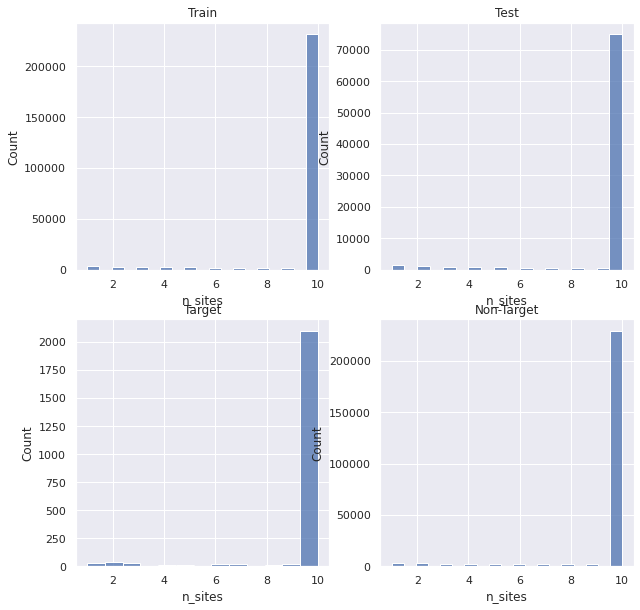

In [49]:
plot_feature(site_features_train, site_features_test, 'histplot', 'n_sites')

#### Топ-10 сайтов

In [50]:
site_counts = {}
for session in df_train_sites.values:
    for site in session:
        if site in site_counts:
            site_counts[site] += 1
        else:
            site_counts[site] = 1
site_counts.pop(0)
top10 = [k for k, _ in sorted(site_counts.items(), key=lambda item: item[1], reverse=True)][:10]
top10

[21, 23, 782, 22, 29, 167, 780, 778, 52, 812]

In [51]:
for site_id in top10:
    print(id2site[site_id])

www.google.fr
www.google.com
annotathon.org
apis.google.com
www.facebook.com
www.bing.com
blast.ncbi.nlm.nih.gov
www.ncbi.nlm.nih.gov
clients1.google.com
mail.google.com


In [ ]:
%%time
site_features = pd.DataFrame()
site_features['has_top10'] = df_train_sites.apply(lambda session: session.isin(top10).any().astype('int'), axis=1)

In [ ]:
feature_hist('has_top10', site_features)

#### Число уникальных сайтов

In [ ]:
%%time
site_features['n_unique'] = df_train[sites].apply(lambda session: session.nunique(), axis=1)

In [ ]:
feature_hist('n_unique', site_features)

#### Абсолютно уникальные сайты

In [ ]:
absolutely_unique_sites.update(df_train_sites.iloc[0])

In [ ]:
a = set()
b = set(df_train_sites.iloc[0])
a, b

In [ ]:
b = set(df_train_sites.iloc[2])
b

In [ ]:
a.symmetric_difference_update(b)
a

In [ ]:
a.update(b)
a

In [ ]:
a.difference_update(a)

In [ ]:
absolutely_unique_sites, full_sites = set()
for session in df_train_sites.values:
    uniques = set(session)
    uniques.difference_update(full_sites)
    absolutely_unique_sites.update(uniques)

In [ ]:
len(absolutely_unique_sites)

In [ ]:
absolutely_unique_sites

In [ ]:
site_counts[13122]

In [ ]:
id2site[13122]

In [ ]:
set_of_sites = set()
for session in df_train_sites.values:
    set_of_sites.update(session)
len(set_of_sites)

In [ ]:
set_of_sites_target = set()
for session in df_train_sites[y_train == 1].values:
    set_of_sites_target.update(session)
len(set_of_sites_target)

In [ ]:
len(set_of_sites_target.intersection(set_of_sites))

TBD

===============================

In [ ]:
class AttributesAdder(BaseEstimator, TransformerMixin):
    """
    Add new attributes to training and test set.
    """ 
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        # intraday features
        hour = X['time1'].apply(lambda ts: ts.hour)
        morning = ((hour >= 7) & (hour <= 11)).astype('int')
        day = ((hour >= 12) & (hour <= 18)).astype('int')
        evening = ((hour >= 19) & (hour <= 23)).astype('int')
        
        # season features
        month = X['time1'].apply(lambda ts: ts.month)
        summer = ((month >= 6) & (month <= 8)).astype('int')
        
        # day of the week features
        weekday = X['time1'].apply(lambda ts: ts.weekday()).astype('int')
        #     is_monday = np.isin(weekday, [0])
        #     is_wednesday = np.isin(weekday, [2])
        #     is_sunday = np.isin(weekday, [6])
        #     is_weekend = np.isin(weekday, [0, 2, 6])
        #     weekdays = pd.get_dummies(weekday.flatten()).to_numpy().reshape(7, -1, 1)
        
        # year features
        year = X['time1'].apply(lambda ts: ts.year).astype('int') #/ 1e3
#         year_month = X['time1'].apply(lambda t: 100 * t.year + t.month) / 1e5

        times = ['time%s' % i for i in range(1, 11)]
        session_duration = (X[times].max(axis=1) - X[times].min(axis=1)).astype('timedelta64[ms]').astype(int) #** 0.2
        
        X = np.c_[morning.values, day.values, evening.values]

        return X

In [ ]:
# class ScaledAttributesAdder(BaseEstimator, TransformerMixin):
#     """
#     Add new features, that should be scaled.
#     """
#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         # session time features
#         times = ['time%s' % i for i in range(1, 11)]
#         sites = ['site%s' % i for i in range(1, 11)]
        
#         # session duration: take to the power of 1/5 to normalize the distribution
#         session_duration = (X[times].max(axis=1) - X[times].min(axis=1)).astype('timedelta64[ms]').astype(int) #** 0.2
        
#         # number of sites visited in a session
#         number_of_sites = X[times].isnull().sum(axis=1).apply(lambda x: 10 - x)
        
#         # average time spent on one site during a session
#         time_per_site = (session_duration / number_of_sites) #** 0.2
        
# #         unique_sites = X[sites].apply(lambda sites: sites.nunique(), axis=1)
        
#         X = np.c_[session_duration.values]
#         return X

In [ ]:
attributes_pipeline = Pipeline([
    ("adder", AttributesAdder()),
    ("scaler", StandardScaler())
])

# scaled_attributes_pipeline = Pipeline([
#     ("adder", ScaledAttributesAdder()),
#     ("scaler", StandardScaler())
# ])

# feature_pipeline = FeatureUnion(transformer_list=[
#     ('attributes_pipeline', attributes_pipeline),
#     ('scaled_attributes_pipeline', scaled_attributes_pipeline)
# ])

In [ ]:
%%time
X_train_features = attributes_pipeline.fit_transform(df_train)

In [ ]:
X_train = hstack([X_train_vectorized, X_train_features])
X_train

=========================================

#### Feature selection

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train_features = pd.concat([time_features, site_features], axis=1)
X_train_features

In [ ]:
X_train_features_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train_features), columns=X_train_features.columns)
X_train_features_scaled

In [ ]:
X_train = hstack([X_train_vectorized, pd.DataFrame(X_train_features_scaled[['morning', 'evening', 
                                                                            'midday', 'weekend', 'summer', 
                                                                            'year', 'duration']])])
X_train

In [ ]:
# pd.DataFrame(X_train_features, columns=feature_names)

### Модель

In [ ]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

#### Обучение и подбор гиперпараметров

In [ ]:
model = SGDClassifier(loss='log', random_state=2179, n_jobs=-1)
time_split = TimeSeriesSplit(n_splits=10)

In [ ]:
model.get_params()

In [ ]:
# grid = {
#     'penalty': ['l2'],
#     'alpha': np.linspace(3e-05, 5e-05, 11)
# }

In [ ]:
# %%time

# search = GridSearchCV(model, param_grid=grid, cv=time_split, scoring='roc_auc')
# search.fit(X_train, y_train)

In [ ]:
# search.best_params_, search.best_score_

=======================================================

In [ ]:
%%time

# sites = ['site%s' % i for i in range(1, 11)]

cv_scores = cross_val_score(model, X_train_vectorized, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)

In [ ]:
cv_scores, cv_scores.mean(), cv_scores.std()

0.9197500019625826

0.9315069358401142,
 0.044345068769381366 0 2 6

0.9180564468510812,
 0.05889198351691508 baseline

0.9232962337585114,
 0.058257317090901546

0.9287111177172779,
 0.04434090003756869 2

### Тест

In [ ]:
import eli5
import calendar

def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                               
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [ ]:
%%time
X_test_vectorized = vectorizer_pipeline.transform(df_test)
X_test_features = attributes_pipeline.transform(df_test)
X_test = hstack([X_test_vectorized, X_test_features])

X_test

In [ ]:
# search.best_estimator_.fit(X_train, y_train)
# logit_test_pred_proba = search.best_estimator_.predict_proba(X_test)
model.fit(X_train, y_train)
logit_test_pred_proba = model.predict_proba(X_test)

In [ ]:
# pd.DataFrame({'feature': feature_names, 'coef': search.best_estimator_.coef_.flatten()[-len(feature_names):]})

In [ ]:
eli5.show_weights(estimator=search.best_estimator_, feature_names=vectorizer_pipeline['vectorizer'].get_feature_names() \
                  + feature_names, top=30)

In [ ]:
write_to_submission_file(logit_test_pred_proba[:, 1], 'result.csv')